In [12]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

import config

In [5]:
img_path = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460320.jpg"

In [6]:
img = cv2.imread(str(img_path))

In [7]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

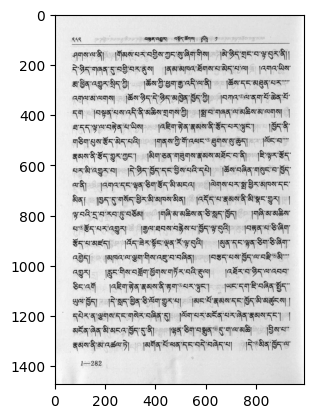

In [23]:
plt.imshow(gray, cmap="gray")
plt.show()

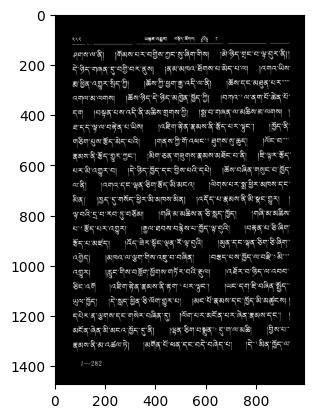

True

In [41]:
def thresholding(image, imshow=False):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
    if imshow: plt.imshow(thresh, cmap='gray'); plt.show()
    return thresh

thresh_img = thresholding(img, imshow=True)
cv2.imwrite("binary.jpg", thresh_img)

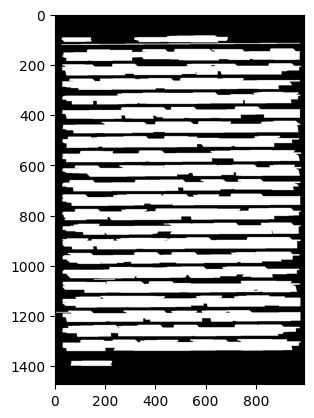

In [32]:
def dilation(thresh_img, imshow=False):
    kernel = np.ones((3,85), np.uint8)
    dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
    if imshow: plt.imshow(dilated, cmap='gray'); plt.show()
    return dilated

dilated_img = dilation(thresh_img, imshow=True)

In [16]:
def find_contours(dialted_img):
    (contours, heirarchy) = cv2.findContours(dialted_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    return sorted_contours_lines

sorted_contours_lines = find_contours(dilated_img)

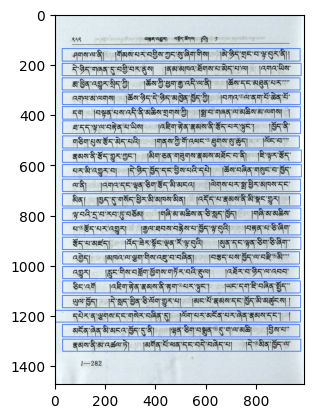

In [21]:
img2 = img.copy()

for ctr in sorted_contours_lines:
    
    x,y,w,h = cv2.boundingRect(ctr)
    if h < 30: continue
    cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)
    
plt.imshow(img2);

In [34]:
def get_lines(img, imshow=False):
    """Returns text lines."""
    thresh_img = thresholding(img, imshow=imshow)
    dilated_img = dilation(thresh_img, imshow=imshow)
    sorted_contours_lines = find_contours(dilated_img)

    # filter out one text lines
    if imshow: img2 = img.copy()
    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        if h < 30: continue
        if imshow: cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2); plt.imshow(img2)
        yield x, y, w, h

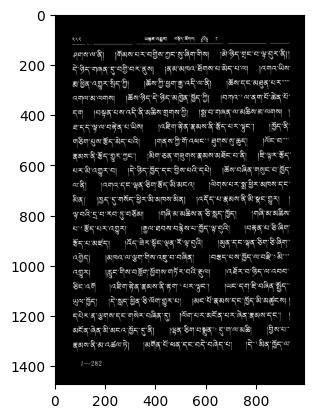

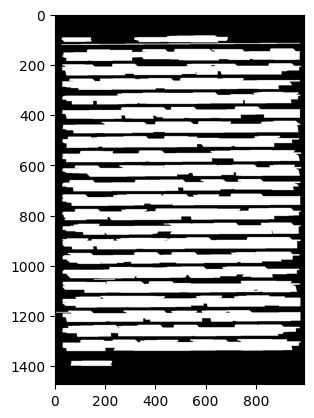

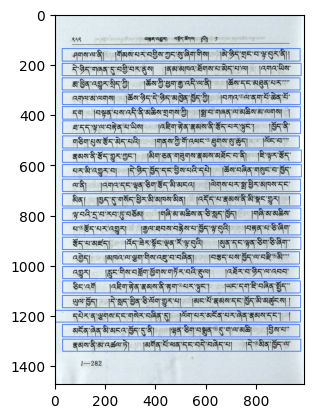

In [35]:
lines = list(get_lines(img, imshow=True))

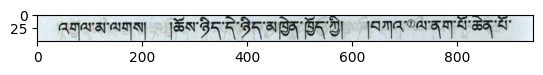

In [39]:
x, y, w, h = lines[3]
plt.imshow(img[y:y+h, x:x+w])